Goal: Explore the dataset of EPSP and impedance properties (measured at multiple morphological locations) for each connection with >5 synapses (impedance frequency = 0 Hz) -- try to understand if there is evidence for the primary dendrite acting to reduce the amount of variation in transfer resistances between neurons. 

In [1]:
from pop_mc_model import *

In [73]:
conns = pd.read_csv('21-02-17_attrs_per_LHNinput.csv')

In [74]:
conns = conns.dropna(subset=['pre_name']) # drop input connections with un-labelled input names

In [43]:
conns.columns

Index(['post_name', 'post_id', 'pre_name', 'pre_id', 'syns', 'syn_count',
       'syn_budget', 'perc_in_dendr', 'num_instances', 'stim',
       'uEPSP_max_dendr_start', 'uEPSP_max_dendr_first_branch',
       'uEPSP_max_ax_start', 'uEPSP_max_ax_first_branch', 'uEPSP_max_soma',
       'mean_Zi', 'std_Zi', 'mean_dist_to_soma', 'std_dist_to_soma',
       'mean_Zc_to_soma', 'std_Zc_to_soma', 'mean_K_to_soma', 'std_K_to_soma',
       'mean_dist_to_ax_start', 'std_dist_to_ax_start', 'mean_Zc_to_ax_start',
       'std_Zc_to_ax_start', 'mean_K_to_ax_start', 'std_K_to_ax_start',
       'mean_dist_to_dendr_first_branch', 'std_dist_to_dendr_first_branch',
       'mean_Zc_to_dendr_first_branch', 'std_Zc_to_dendr_first_branch',
       'mean_K_to_dendr_first_branch', 'std_K_to_dendr_first_branch'],
      dtype='object')

Restrict connections to ePN inputs. 

If we had a multi-factor linear model to predict uEPSP size, what would we include in it (beyond our current hypothesis of synaptic budget)? We could probably get really close by leveraging impedance measures, but ideally we want to pull out measures that are morphology only, so that someone could pull them out without simulating in NEURON. 
If we find a different measure that better describes the MODEL uEPSPs than synaptic budget, how accurately would it reflect the most important elements of morphology that predict functional connectivity strength? the primary map back to experimental data would just be through the biophysical parameter fit and the use of traced hemibrain neurons. 

Do the same neurons that have same synaptic budget but different uEPSPs in the model show up with that pattern in the experimental data? 

In [81]:
conns_ePN = conns.loc[conns.pre_name.str.contains('_adPN') | conns.pre_name.str.contains('_lPN')]
conns_ePN

,post_name,post_id,pre_name,pre_id,syns,syn_count,syn_budget,perc_in_dendr,num_instances,stim,...,mean_Zc_to_ax_start,std_Zc_to_ax_start,mean_K_to_ax_start,std_K_to_ax_start,mean_dist_to_dendr_first_branch,std_dist_to_dendr_first_branch,mean_Zc_to_dendr_first_branch,std_Zc_to_dendr_first_branch,mean_K_to_dendr_first_branch,std_K_to_dendr_first_branch
1,local2,5813055963,DL5_adPN,693483018,List[15],51,0.153153,0.705882,1,[NetStim[1]],...,909.081694,123.404285,0.557279,0.184087,38.851396,27.168891,907.622112,119.465637,0.556375,0.182592
5,local2,5813055963,DM3_adPN,755518957,List[23],9,0.027027,1.000000,1,[NetStim[5]],...,755.760681,234.604593,0.385720,0.187109,69.685255,54.139854,760.861026,236.187852,0.388323,0.188372
8,local2,666450841,DP1l_adPN,724816115,List[34],14,0.012478,1.000000,1,[NetStim[8]],...,428.054689,40.792546,0.165142,0.042519,68.046014,28.304031,431.125612,41.085198,0.166327,0.042824
19,local2,666450841,DL5_adPN,693483018,List[56],80,0.071301,0.537500,1,[NetStim[19]],...,507.174850,30.998671,0.465391,0.156008,43.462285,20.372183,505.651188,31.532206,0.463633,0.154337
27,local2,666450841,DM4_adPN,573333835,List[72],8,0.007130,0.875000,1,[NetStim[27]],...,490.210401,52.213194,0.304481,0.060522,45.677962,14.577185,492.292095,51.852095,0.305516,0.058841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,V2,851961337,DC3_adPN,"5813039471, 1857825571, 1858171399",List[1894],24,0.022923,1.000000,3,[NetStim[833]],...,565.746520,4.444988,0.394650,0.073056,43.295480,7.567585,579.401628,4.552274,0.404175,0.074820
845,V2,851961337,M_adPNm7,1886132855,List[1918],13,0.012416,1.000000,1,[NetStim[845]],...,558.382450,3.809005,0.396910,0.089860,46.777503,4.880574,571.859816,3.900941,0.406490,0.092029
847,V2,851961337,M_adPNm8,1762674761,List[1922],5,0.004776,1.000000,1,[NetStim[847]],...,559.073646,4.414767,0.470646,0.078015,46.798489,6.060600,572.567695,4.521324,0.482006,0.079898
850,V2,851961337,VA1d_adPN,"5813055162, 1851061177",List[1928],14,0.013372,1.000000,2,[NetStim[850]],...,563.344035,2.890090,0.323704,0.036576,53.810307,2.441231,576.941155,2.959847,0.331517,0.037459


In [44]:
conns_dendr = conns.loc[conns.perc_in_dendr > 0.85]
conns_dendr.shape

(517, 35)

In [45]:
conns_dendr.loc[conns_dendr.post_name=='L1', ['post_id', 'pre_name', 'syn_count', 'perc_in_dendr',
                                              'mean_Zi', 'std_Zi']]
# we see a lot of variance in mean_Zi of connections, within the same body ID

,post_id,pre_name,syn_count,perc_in_dendr,mean_Zi,std_Zi
319,454045389,LHPV6g1,5,1.0,3422.808793,828.332792
320,454045389,NaN,6,1.0,2903.963967,634.917180
321,454045389,LHAV4g4_a,7,1.0,3226.921606,955.786282
322,454045389,LHAV6b1_b,5,1.0,3198.785407,749.068102
323,454045389,VM7d_adPN,5,1.0,3015.209796,305.213423
324,454045389,LHPD4c1,5,1.0,2758.205841,792.978581
325,454045389,DM1_lPN,6,1.0,2531.214016,505.635458
327,454045389,SLP057,6,1.0,2079.292234,278.655052
328,454045389,M_vPNml78,5,1.0,2193.765323,242.601680
329,454045389,DC1_adPN,6,1.0,5608.148431,1266.212376


<IPython.core.display.Javascript object>


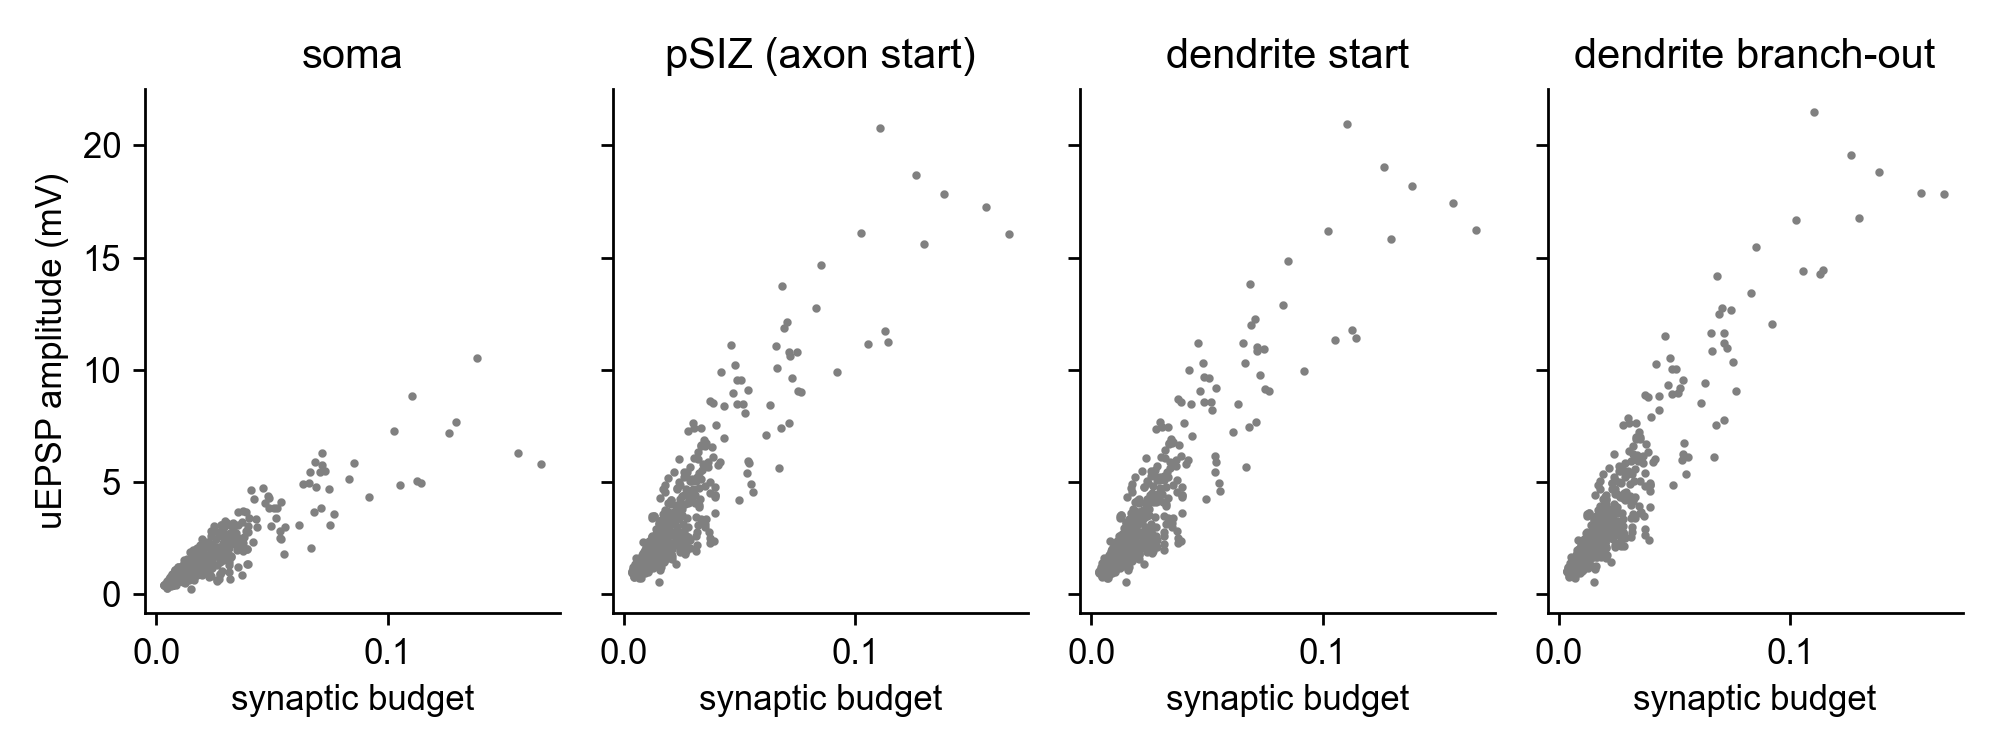

In [14]:
%matplotlib notebook
fig, axs = plt.subplots(nrows=1,ncols=4, figsize=(8,3), sharey=True, sharex=True)

axs[0].scatter(conns_dendr.syn_budget, conns_dendr.uEPSP_max_soma, s=2, color='grey')
axs[0].set(ylabel='uEPSP amplitude (mV)', xlabel='synaptic budget', title='soma')
axs[1].scatter(conns_dendr.syn_budget, conns_dendr.uEPSP_max_ax_start, s=2, color='grey')
axs[1].set(title='pSIZ (axon start)', xlabel='synaptic budget')
axs[2].scatter(conns_dendr.syn_budget, conns_dendr.uEPSP_max_dendr_start, s=2, color='grey')
axs[2].set(title='dendrite start', xlabel='synaptic budget')
axs[3].scatter(conns_dendr.syn_budget, conns_dendr.uEPSP_max_dendr_first_branch, s=2, color='grey')
axs[3].set(title='dendrite branch-out', xlabel='synaptic budget')

for i in range(4):
    axs[i].spines["top"].set_visible(False), axs[i].spines["right"].set_visible(False)
    
plt.tight_layout()

If the primary dendrite acted to normalize the transfer resistance across neurons (such that dendritic arbors with smaller input resistances have larger transfer ratios, and vice versa), we would expect the variance in Zc measured at the soma to be SMALLER than the variance in Zc measured at the dendrite first branch. This does not seem to be the case. 

<IPython.core.display.Javascript object>


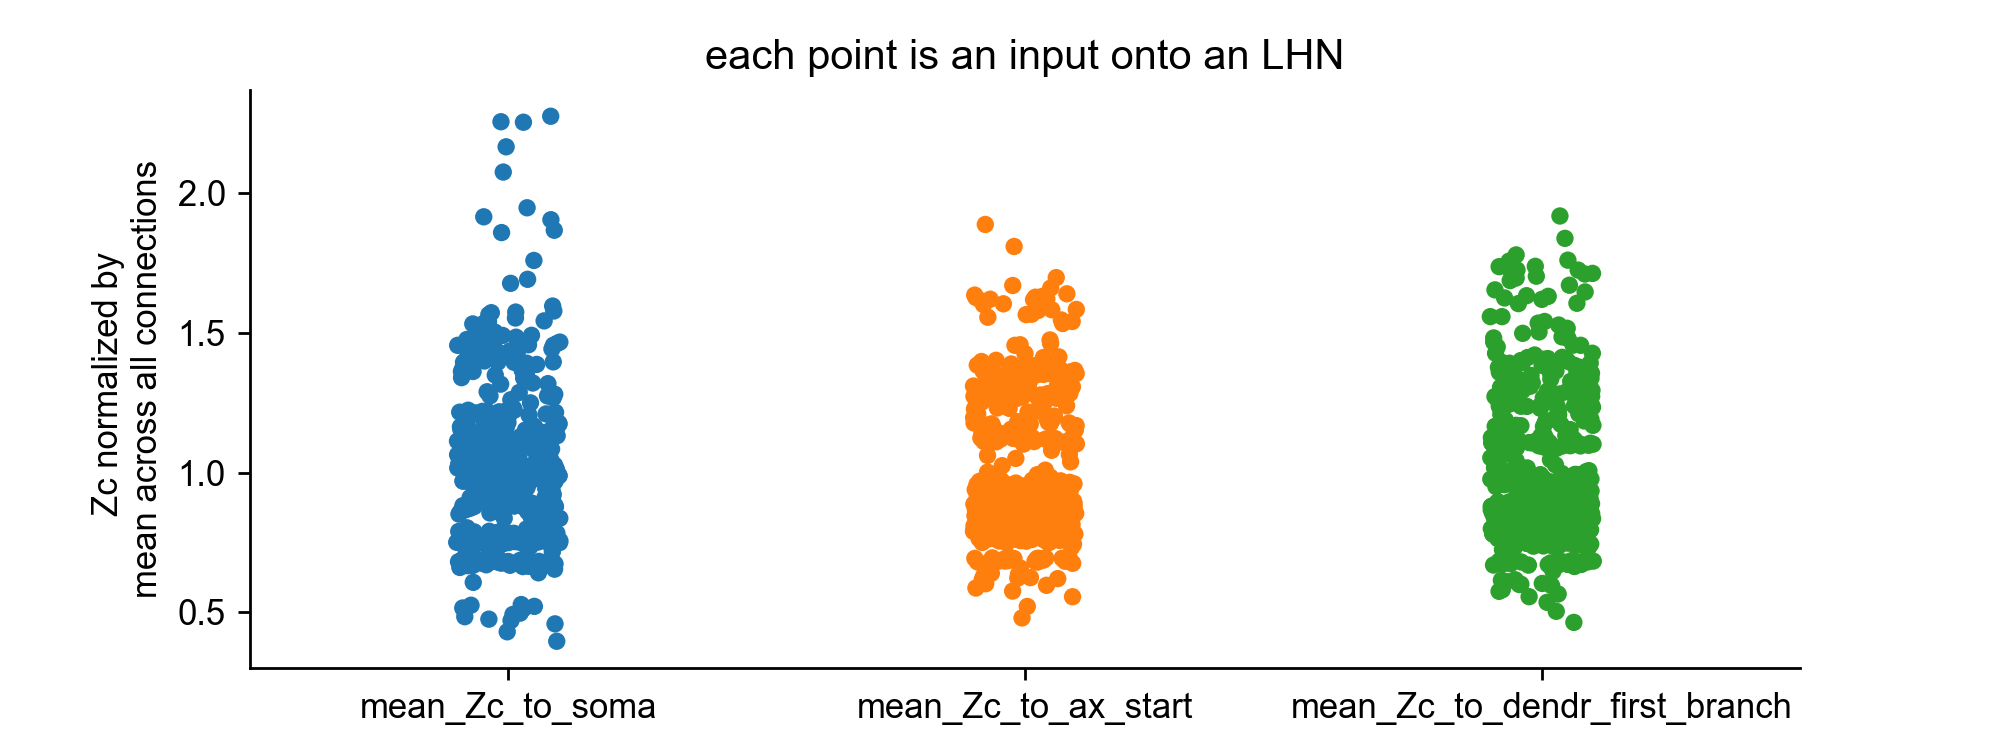

(None, None)

In [26]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
zc_across_dconns = conns_dendr[['mean_Zc_to_soma', 'mean_Zc_to_ax_start', 'mean_Zc_to_dendr_first_branch']]
zc_across_dconns = zc_across_dconns.apply(lambda x: x/mean(x))
ax = sns.stripplot(data=zc_across_dconns, ax=ax)
ax.set(ylabel='Zc normalized by \nmean across all connections', title='each point is an input onto an LHN')
ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)

<IPython.core.display.Javascript object>


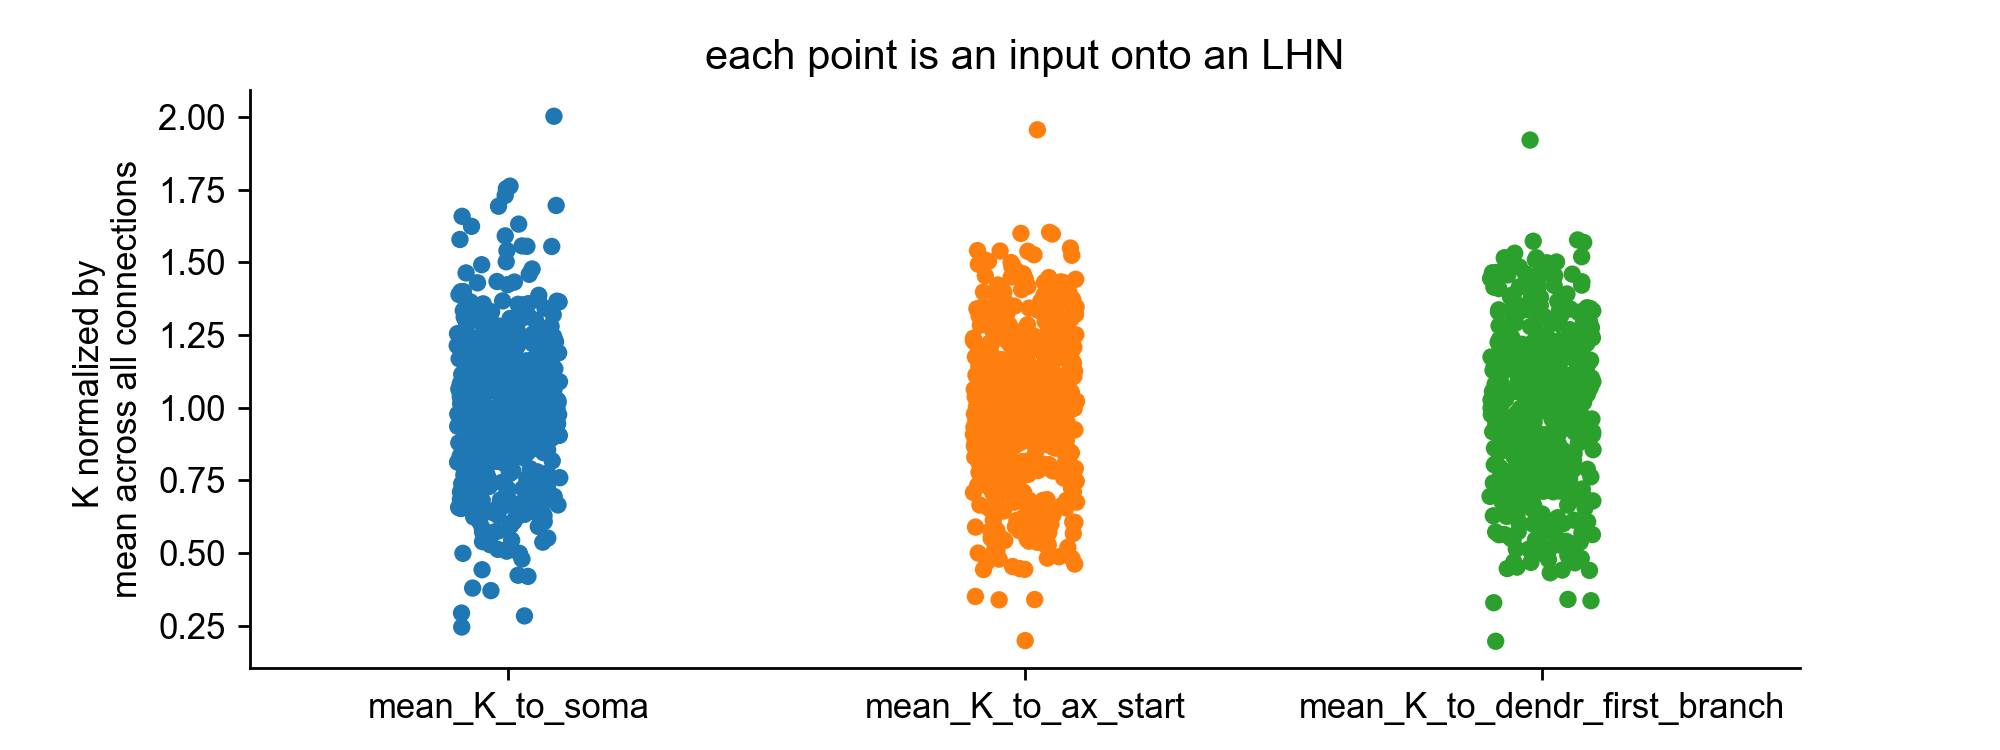

(None, None)

In [36]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
k_across_dconns = conns_dendr[['mean_K_to_soma', 'mean_K_to_ax_start', 'mean_K_to_dendr_first_branch']]
k_across_dconns = k_across_dconns.apply(lambda x: x/mean(x))
ax = sns.stripplot(data=k_across_dconns, ax=ax)
ax.set(ylabel='K normalized by \nmean across all connections', title='each point is an input onto an LHN')
ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)

For EACH connection, is the CV of transfer resistance smaller than the CV of input resistance? I interpret it as, at the single neuron level, does the primary dendrite serve to make mEPSPs appear more similar? 

<IPython.core.display.Javascript object>


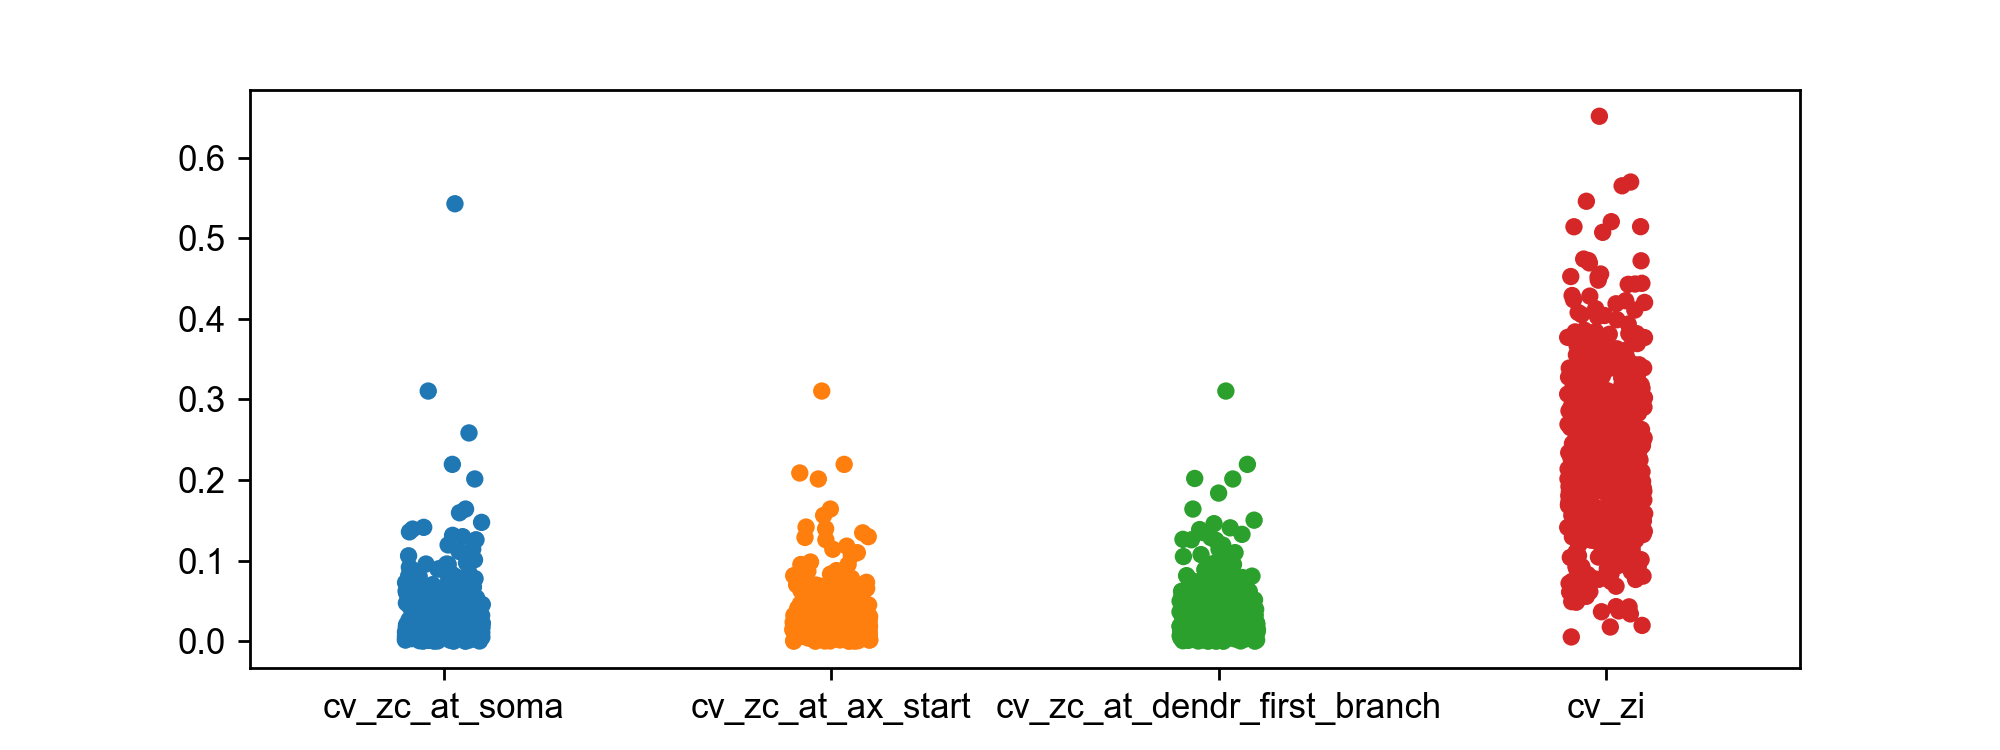

In [50]:
cvs = pd.DataFrame()
cvs['cv_zc_at_soma'] = conns_dendr['std_Zc_to_soma'] / conns_dendr['mean_Zc_to_soma']
cvs['cv_zc_at_ax_start'] = conns_dendr['std_Zc_to_ax_start'] / conns_dendr['mean_Zc_to_ax_start']
cvs['cv_zc_at_dendr_first_branch'] = conns_dendr['std_Zc_to_dendr_first_branch'] / conns_dendr['mean_Zc_to_dendr_first_branch']
cvs['cv_zi'] = conns_dendr['std_Zi'] / conns_dendr['mean_Zi']
fig, ax = plt.subplots(figsize=(8,3))
ax = sns.stripplot(data=cvs, ax=ax)

Compute average input resistance for dendritic-targeting connections onto LHNs, graph against their K across primary dendrite. 

In [53]:
k_PD = pd.read_csv('21-02-17_k_across_primary_dendrite.csv')

In [54]:
# average input resistance across all dendritic targeting connections, per LHN
avg_zi = conns_dendr.groupby(['post_id'])['mean_Zi'].mean()

<IPython.core.display.Javascript object>


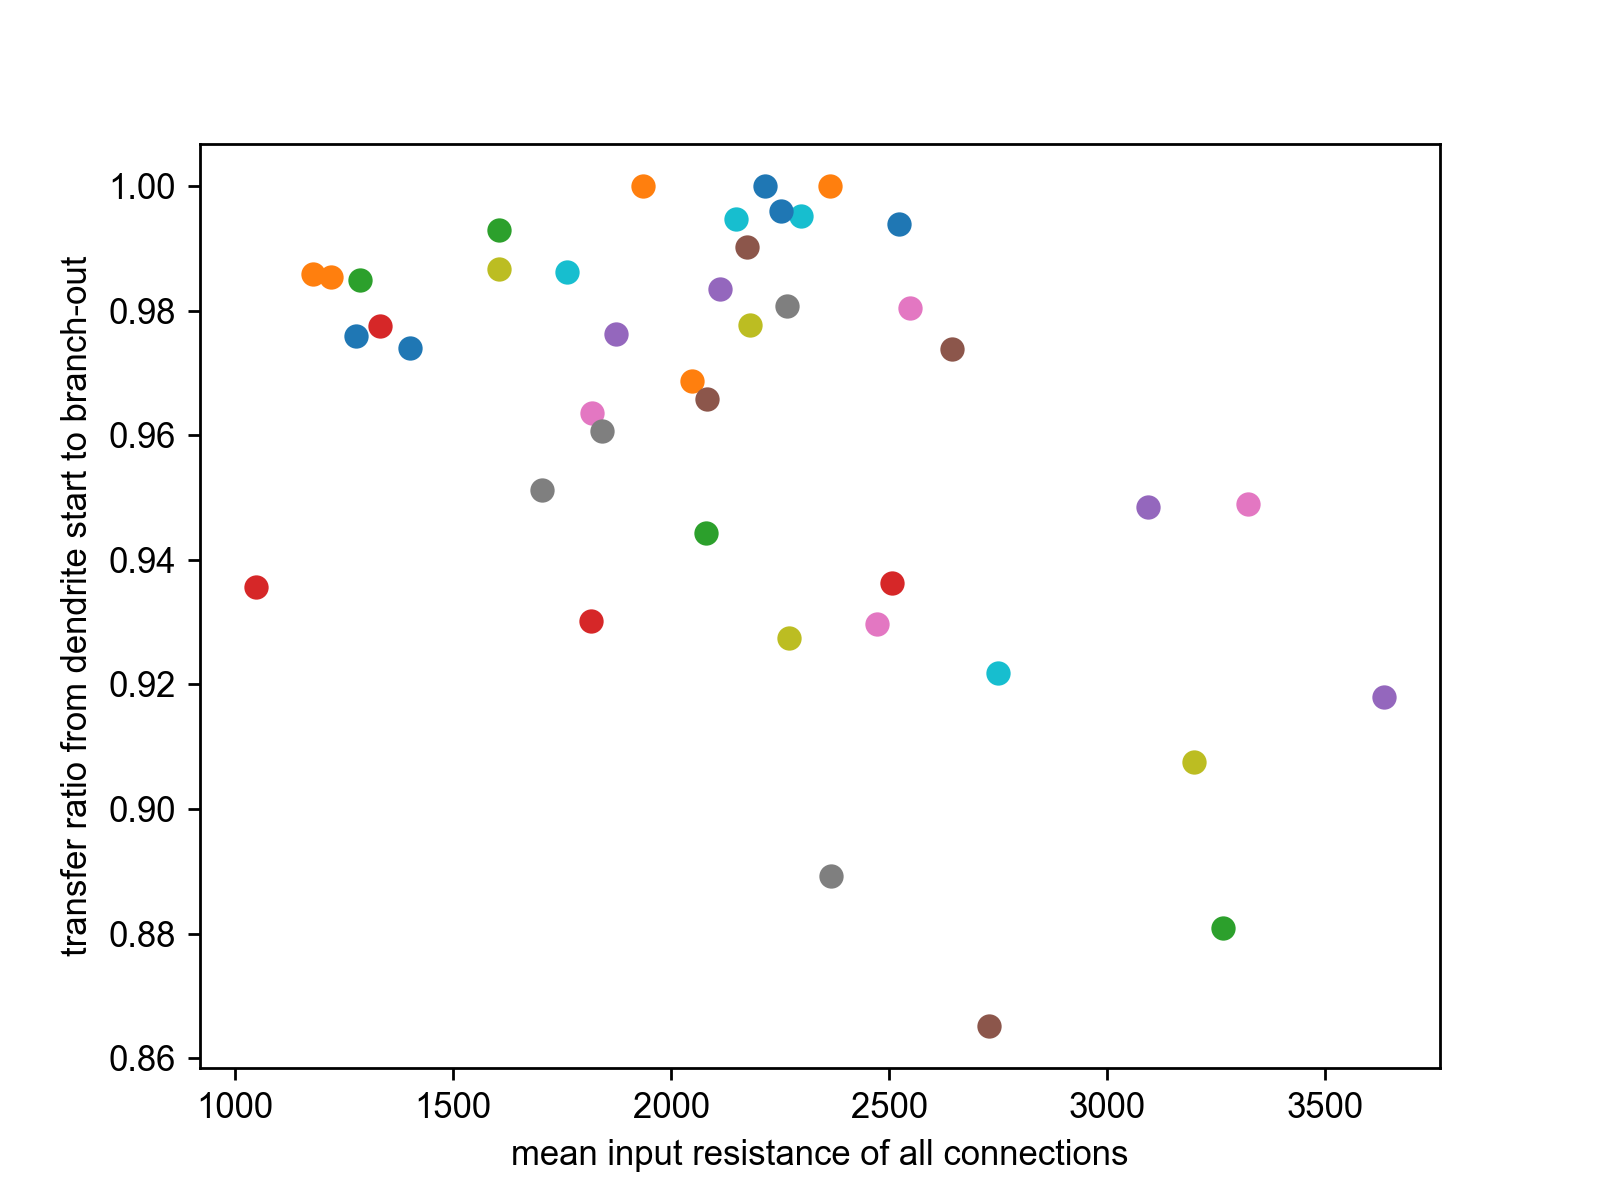

no dendrite targeting inputs:  579562628 L12
no dendrite targeting inputs:  573329304 ML9


[Text(0.5, 0, 'mean input resistance of all connections'),
 Text(0, 0.5, 'transfer ratio from dendrite start to branch-out')]

In [62]:
fig, ax = plt.subplots()
for i, row in k_PD.iterrows():
    try:
        ax.scatter(avg_zi[row.target_body_id], row.k_dstart_dbranch)
    except:
        print('no dendrite targeting inputs: ', row.target_body_id, row.target_name)
        
ax.set(xlabel = 'mean input resistance of all connections', ylabel = 'transfer ratio from dendrite start to branch-out')

It seems that there's a weak inverse correlation between the mean input resistance and the transfer ratio, but that it might not be strong enough to show up at the uEPSP level (perhaps at the mEPSP level?). 